In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv('../input/data-storm-10/credit_card_default_train.csv')

* **Correlation matrix for features**

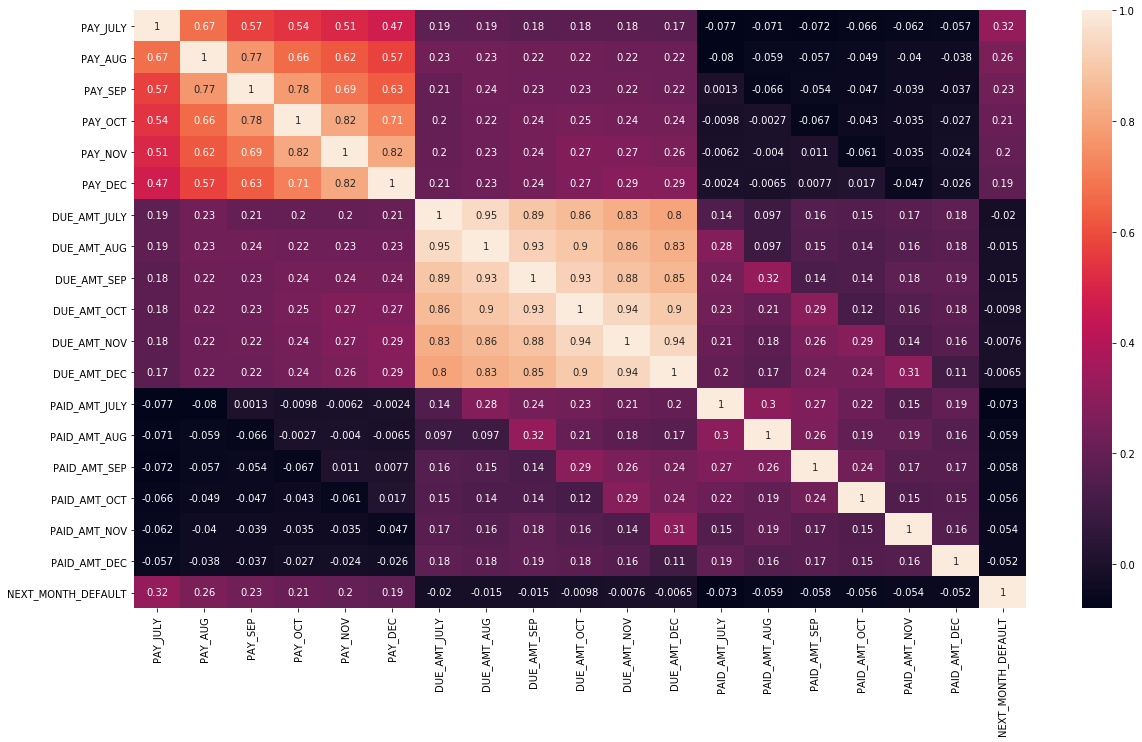

In [3]:
plt.figure(figsize=(20,11))
sns.heatmap(data.corr(),annot=True)

In [4]:
Y = data.NEXT_MONTH_DEFAULT

In [5]:
print (sum(Y==1),sum(Y==0))

5330 18670


In [6]:
def newline(value):
    if value[-1] =='K':
        return float(value[:-1])*1000
    elif value[-1] == 'M':
        return float(value[:-1])*1000000

#filtering 
data['Balance_Limit_V1']= data['Balance_Limit_V1'].apply(newline)

In [7]:
data.drop(['Client_ID'], axis=1, inplace=True)

In [8]:
X = data.drop(['NEXT_MONTH_DEFAULT'], axis=1, inplace=False)

In [9]:
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

In [10]:
label_encoder = LabelEncoder()
for col in set(object_cols):
   X[col] = label_encoder.fit_transform(X[col])

* ****Undersampling****

In [11]:
# Shuffle the Dataset.
shuffled_df = data.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df.NEXT_MONTH_DEFAULT==1]

#Randomly select 492 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df.NEXT_MONTH_DEFAULT==0].sample(n=5330,random_state=42)

# Concatenate both dataframes again
df = pd.concat([fraud_df, non_fraud_df])

In [12]:
y = df.NEXT_MONTH_DEFAULT

In [13]:
print (sum(y==1),sum(y==0))

5330 5330


* **Heatmap after undersampling**

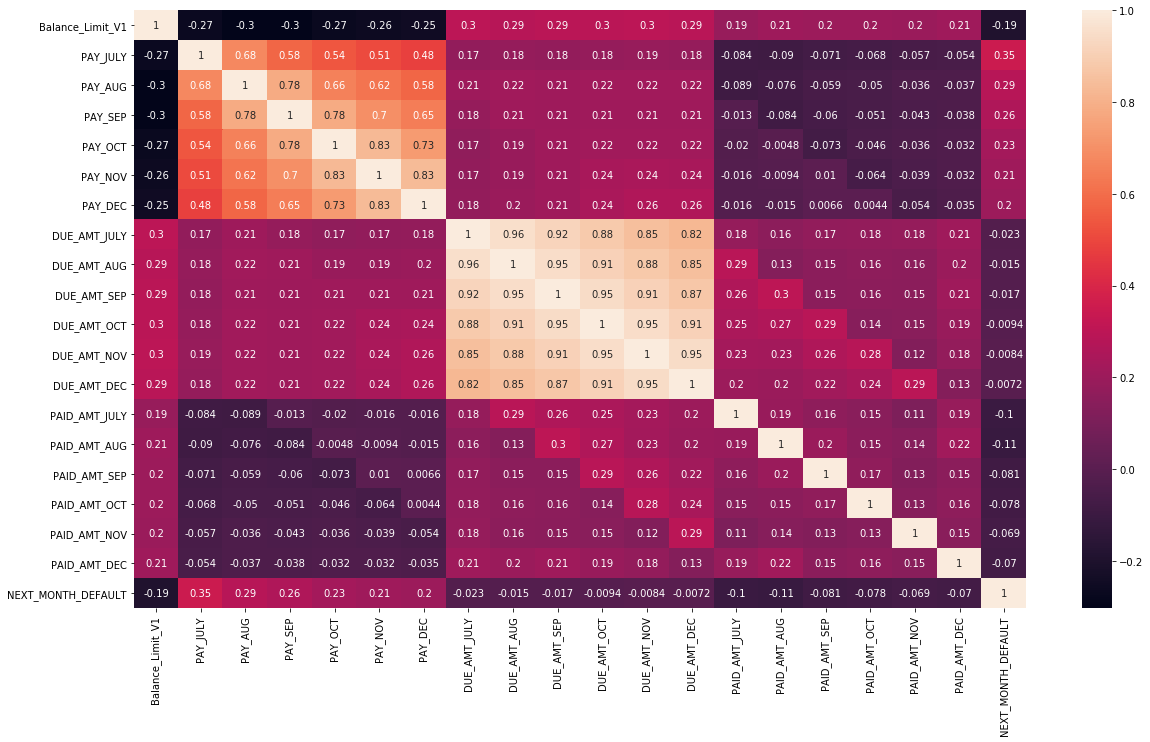

In [14]:
plt.figure(figsize=(20,11))
sns.heatmap(df.corr(),annot=True)

* As we can see even after undersampling the distribution hasn't change Significantly 

In [15]:
output = 'NEXT_MONTH_DEFAULT'

In [16]:
cols = [ f for f in data.columns if data.dtypes[ f ] != "object"]
cols.remove( output )

* **Facegrids for some numerical data**

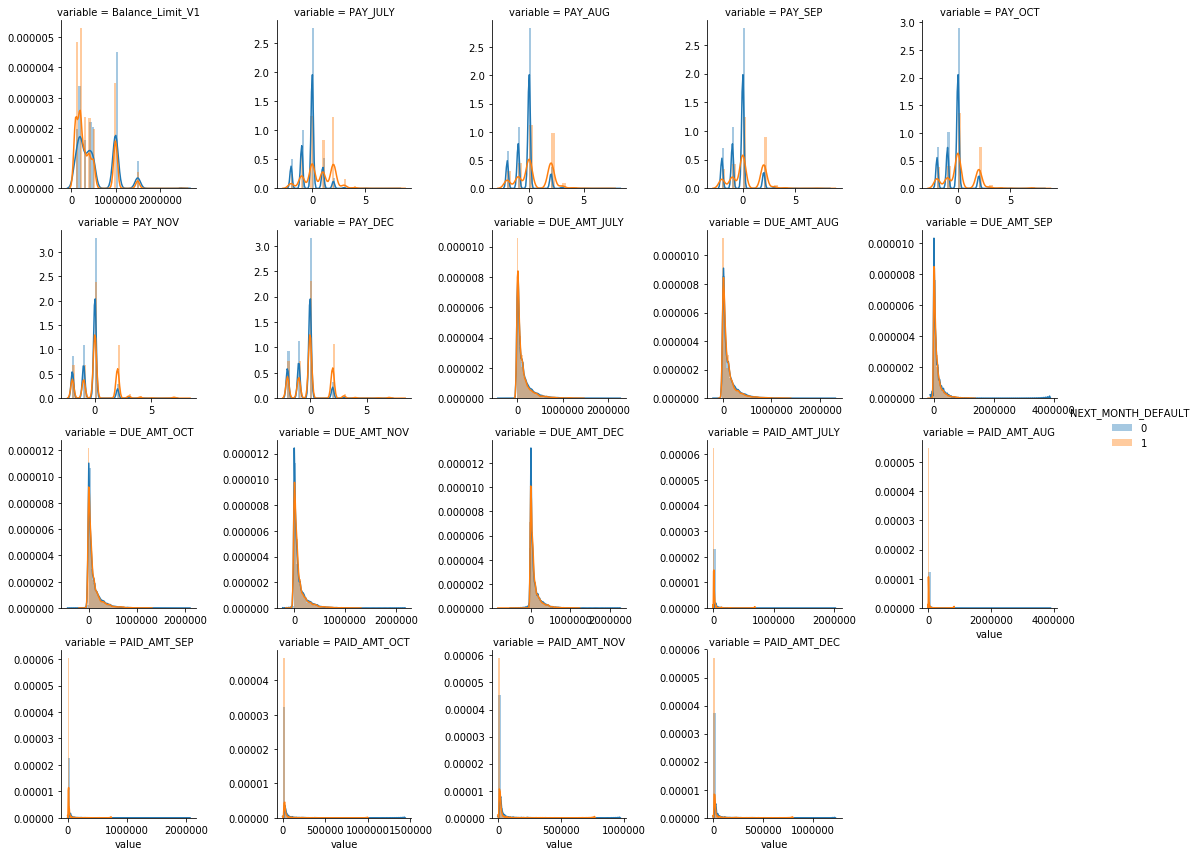

In [17]:
f = pd.melt( data, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

* customers those who pay in advance are generally less tend to be default. 

In [18]:
def corr_(Col1, Col2):
    res = data.groupby([Col1, Col2]).size().unstack()
    res['tot'] = res[res.columns[0]] + res[res.columns[1]]
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
   
    return res

In [19]:
corr_('Gender','NEXT_MONTH_DEFAULT')

NEXT_MONTH_DEFAULT,0,1,tot,perc
Gender,,,,
F,7218,2322,9540,0.243396
M,11452,3008,14460,0.208022


1. there are more men than women
2. but women more tendly to become default than men by next month by 16.8%

In [20]:
corr_('MARITAL_STATUS',"NEXT_MONTH_DEFAULT")

NEXT_MONTH_DEFAULT,0,1,tot,perc
MARITAL_STATUS,,,,
Other,10306,2764,13070,0.211477
Single,8364,2566,10930,0.234767


1. non-single customers are higher
2. but compared to non-single customers, single customers are 10.9% more tend to be default by next month

In [21]:
corr_('EDUCATION_STATUS','NEXT_MONTH_DEFAULT')

NEXT_MONTH_DEFAULT,0,1,tot,perc
EDUCATION_STATUS,,,,
Graduate,6828,1650,8478,0.194621
High School,2939,986,3925,0.251210
Other,8903,2694,11597,0.232301


1. most customers are under the other category but since it is not clearly defined as higher than Graduate level or lower than High Schooling we can't exactly say something about other category
2. but comparing High School to Graduates, high schoolers are 29.3% more tend to be default by next month

In [22]:
corr_('AGE','NEXT_MONTH_DEFAULT')

NEXT_MONTH_DEFAULT,0,1,tot,perc
AGE,,,,
31-45,9599,2525,12124,0.208265
46-65,3129,1021,4150,0.246024
Less than 30,5877,1761,7638,0.230558
More than 65,65,23,88,0.261364


1. customers are mostly under 31-45 age. only 88 out of 24000 customers are over 60 age.
2. interestingly those who are not under the majority group are having a high tendancy to be default.

In [23]:
corr_('Balance_Limit_V1',"NEXT_MONTH_DEFAULT")

NEXT_MONTH_DEFAULT,0,1,tot,perc
Balance_Limit_V1,,,,
100000.0,2207,1242,3449,0.360104
200000.0,3805,1354,5159,0.262454
300000.0,1805,606,2411,0.251348
400000.0,2469,596,3065,0.194454
500000.0,2289,501,2790,0.179570
1000000.0,5061,890,5951,0.149555
1500000.0,1000,138,1138,0.121265
2500000.0,34,3,37,0.081081


1. the distribution in balance limit doesn't have an interesting clear pattern.
2. but as expecting, the customers who have a lower balance limit tends to be default an it has a nice descending pattern. 
3. statistically compared to cutomers with 2.5M balance limit, customers with 100K limit tends to become defaut by 4.44 times  

In [24]:
data[(data.PAID_AMT_OCT>data.Balance_Limit_V1)|(data.PAID_AMT_NOV>data.Balance_Limit_V1) | (data.PAID_AMT_DEC>data.Balance_Limit_V1)][['Balance_Limit_V1',"DUE_AMT_OCT","PAID_AMT_OCT","DUE_AMT_NOV","PAID_AMT_NOV",'DUE_AMT_DEC','PAID_AMT_DEC',"NEXT_MONTH_DEFAULT"]]

,Balance_Limit_V1,DUE_AMT_OCT,PAID_AMT_OCT,DUE_AMT_NOV,PAID_AMT_NOV,DUE_AMT_DEC,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
148,1000000.0,-392700,1148070,396618,23100,402289,16170,0
360,400000.0,299764,97020,314354,80573,70021,464950,0
371,100000.0,5521,0,1802,112312,56156,360,0
2028,400000.0,87637,0,58425,0,29212,401637,0
4964,100000.0,10550,128810,27170,9723,9723,52703,0
6179,100000.0,50751,0,43125,2310,45435,123125,1
8388,200000.0,0,267498,135431,4946,137561,4930,0
9540,200000.0,-15863,0,-20079,346500,125606,23100,0
10256,300000.0,0,0,0,0,-348701,347424,0
11465,400000.0,262361,115782,319748,14941,234354,642898,0


* customers considering there due amounts, in order to not to be default they pay a large amount in some months which exceeds the credit limit.Those who do not get default have a comparably higher credit limit. which implies those customers are richer and they have simply forgot to check and pay dues.

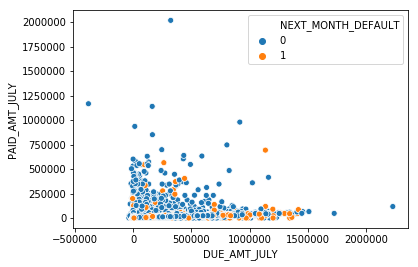

In [25]:
sns.scatterplot(x=data.DUE_AMT_JULY,y=data.PAID_AMT_JULY,hue=data.NEXT_MONTH_DEFAULT)

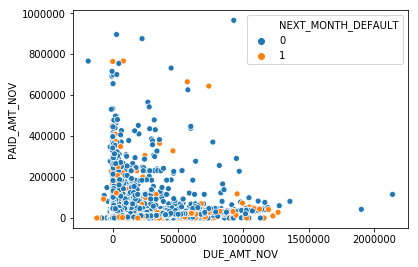

In [26]:
sns.scatterplot(x=data.DUE_AMT_NOV,y=data.PAID_AMT_NOV,hue=data.NEXT_MONTH_DEFAULT)

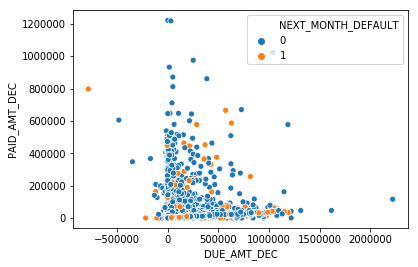

In [27]:
sns.scatterplot(x=data.DUE_AMT_DEC,y=data.PAID_AMT_DEC,hue=data.NEXT_MONTH_DEFAULT)

* because of the imbalance it is hard to say something regarding paid and dues in each month.
* but those who have a higher credit limit have high values in due and pays


In [28]:
data.head()

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,...,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
0,1000000.0,M,Graduate,Other,31-45,-1,-1,-1,-1,-1,...,39418,162772,-13982,3437,6004,39418,162772,0,538165,0
1,1000000.0,F,High School,Other,Less than 30,0,-1,-1,-1,-1,...,43530,80811,124590,151818,46200,43530,80811,942,33666,0
2,100000.0,F,High School,Single,31-45,4,3,2,2,-2,...,0,0,0,0,0,0,0,0,0,1
3,200000.0,F,Graduate,Single,31-45,2,0,0,0,0,...,97309,100353,102740,3855,3890,3696,4620,4049,3918,1
4,1000000.0,F,Graduate,Other,31-45,2,2,0,0,0,...,435354,445271,453899,0,20790,16170,17325,16401,17325,0
